# Comparing segmention measurments to manual measurments

This notebook explores how well vein length measurements extracted from the the neural network segmentations correlate with manual measurments

In [1]:
%qtconsole

In [1]:
import sys
import os
from os.path import join, basename
from pathlib import Path
import matplotlib.pyplot as plt

project_root = os.path.abspath('../')

## Read in the segmentation probabilites

We begin by reading in the vein segmentation probabilites output by the neural network.

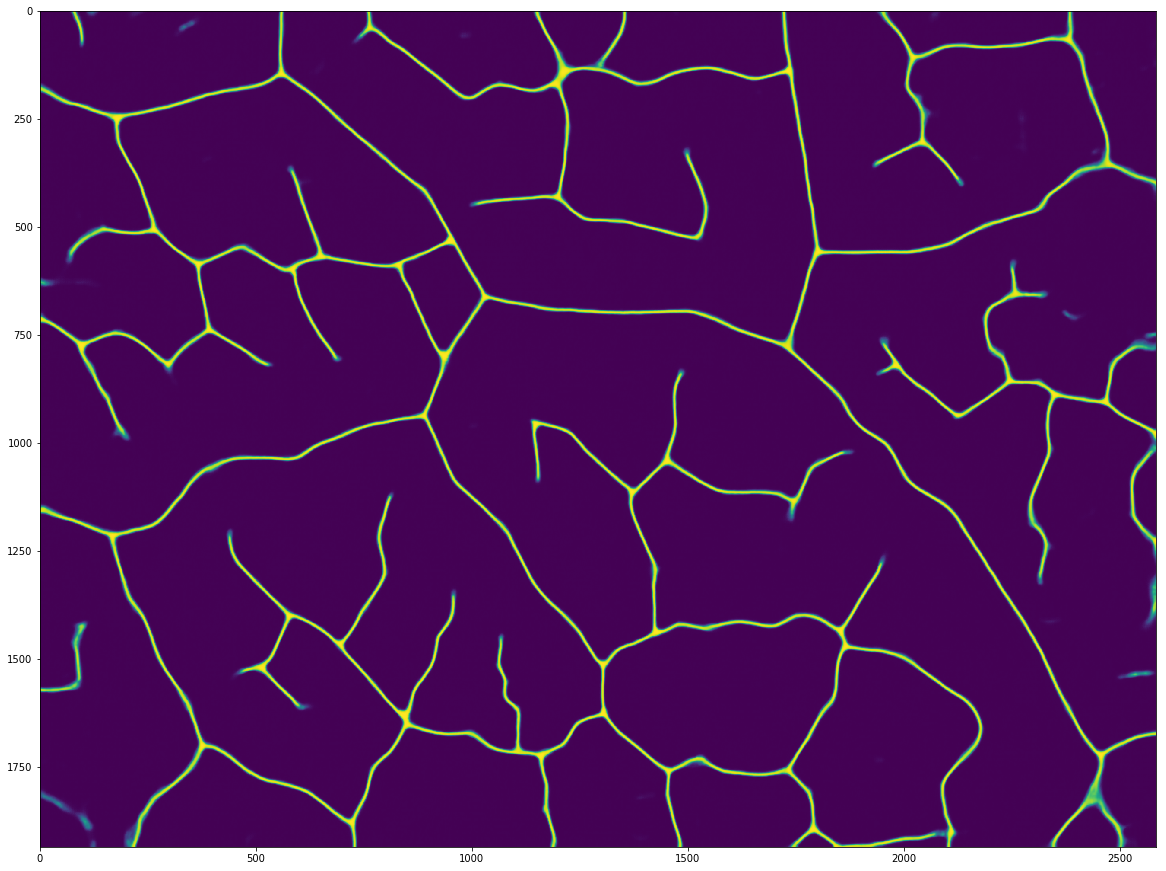

In [2]:
from skimage import io

probs = io.imread(join(project_root,
                       'models','v3',
                       'results','dilations',
                       '17-3_probs.png'))

plt.figure(figsize=(20,20))
plt.imshow(probs)

# Segment Probabilities

The probabilies are converted into a segmentation mask using a theshold of 0.4. 0.4 was chosen by visually inspecting the results of a few threshold values. A more rigorous method of choosing the threshold should be developed. 

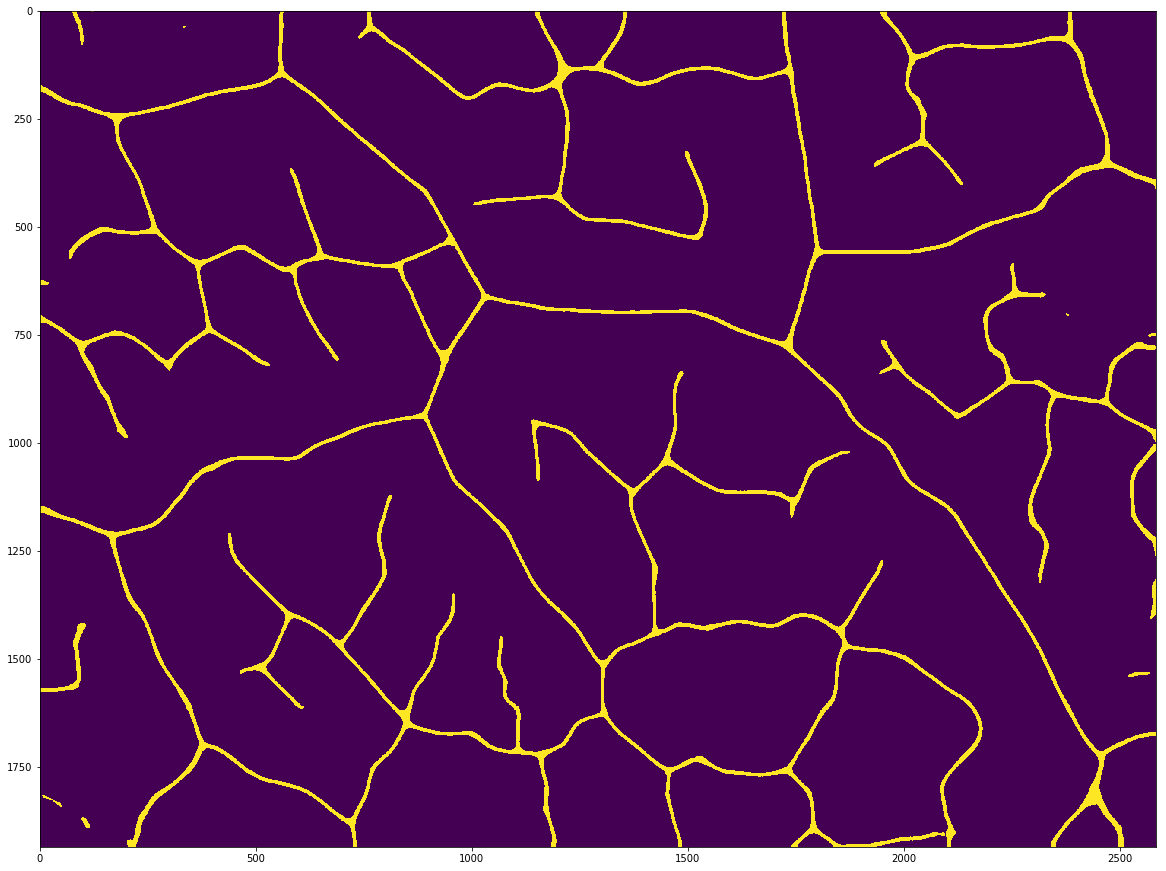

In [3]:
seg = probs/2**16 > 0.4 #The probabilites were saved as p * 2^16.

plt.figure(figsize=(20,20))
plt.imshow(seg)

## Extract a 1 pixel wide skeleton of the segmentation

Reduce the segmentations produced by the network to 1 pixel wide lines (using the medial axis transform). Since all lines are only a pixel wide, the sum of pixels in the lines should correlate well with the true distances in the segmentation.

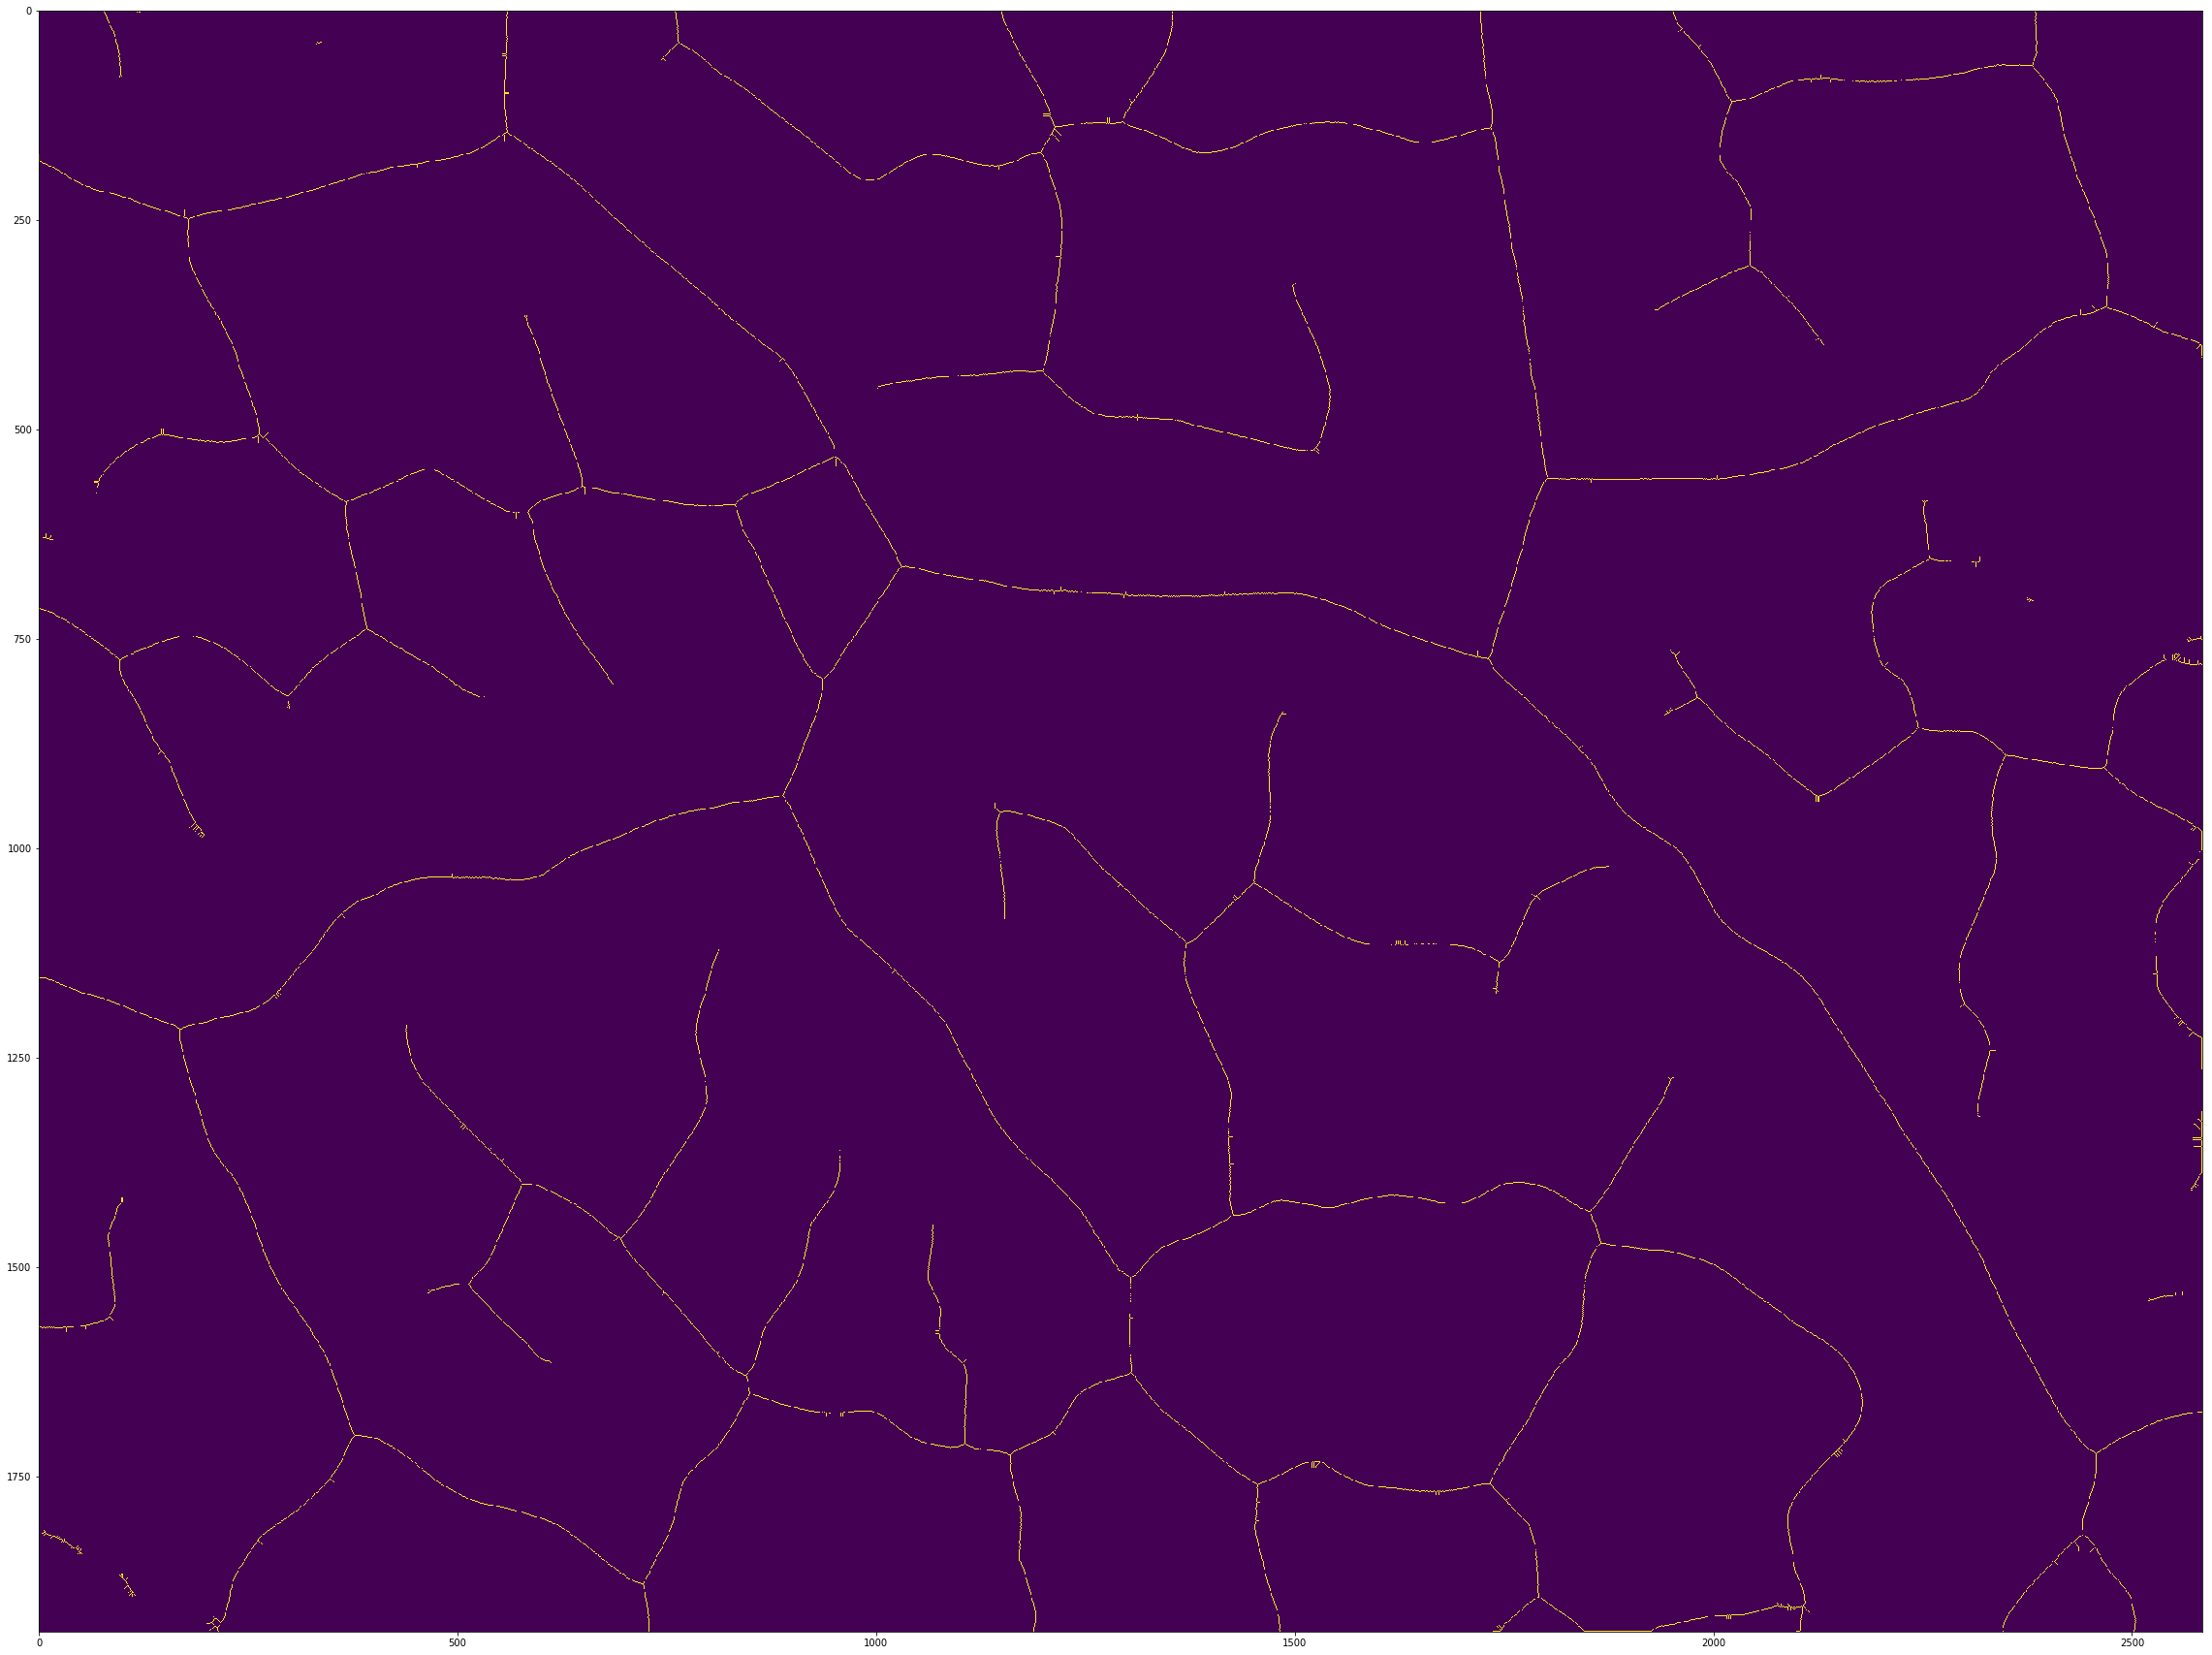

In [4]:
from skimage.morphology import medial_axis

med = medial_axis(seg)

plt.figure(figsize=(40,40))
plt.imshow(med)

## Perform the steps above for all the test images

And save them into the results.sql sqlite database. 

In [106]:
from glob import glob
import dataset
from tqdm import tqdm

db = dataset.connect('sqlite:///results.sql')
table = db['v3_dilations_train']
table.delete()
file_paths = join(project_root,'models','v3','results','dilations','*_probs.png')
for image in tqdm(glob(file_paths)):
    filename = basename(image)
    plant = filename.split('-')[0]
    replicate = filename.split('-')[1][0]
    
    probs = io.imread(image)
    seg = probs/2**16 > 0.4
    med = medial_axis(seg)
    length = np.sum(med)

    table.insert(dict(plant=plant, replicate=replicate, length=int(length)))

100%|██████████| 80/80 [01:41<00:00,  1.08s/it]


## Extract the manual measurments from the csv file

And save them into the results.sql sqlite database. 

In [107]:
from csv import DictReader

table = db['manually_measured']
table.delete()
with open(join(project_root,'data','raw','VeinLengths.csv')) as fin:
    reader = DictReader(fin)
    for row in tqdm(reader):
        if row['Vein Length (um)'] != '':
            filename = row['File Name'].split('-')
            plant = filename[0]
            replicate = filename[1]
            length = row['Vein Length (um)']
            table.insert(dict(plant=plant, replicate=replicate, length=float(length)))
            #print("Plant: %s, Replicate: %s, Length: %s"%(plant, replicate, length))

933it [02:11,  7.12it/s]


## Plot the results

In [2]:
import pandas as pd
import sqlite3
conn = sqlite3.connect("./results.sql")

df_measured = pd.read_sql("SELECT * FROM v3_dilations_train",conn)
df_human = pd.read_sql("SELECT * FROM manually_measured",conn)

In [3]:
df = df_measured.merge(df_human[['plant','replicate','length']],
                       on=["plant","replicate"],
                       how="left",
                       suffixes=("_measured","_human"))

df = df.dropna() #Some human measurments are missing

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.scatter(df['length_measured'],df['length_human'])
plt.xlabel('AI Measured Vein Length (pixels)')
plt.ylabel(r'Human Measured Vein Length ($\mu$m)')

r =  df[['length_measured','length_human']].corr()['length_measured'][1]
plt.text(35000, 17500, r"$R^2$ = %1.5f"%(r**2,))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.savefig('Correlation.png',dpi=100)